In [ ]:
import torch

# Check if using GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f"Nvidia Cuda/GPU is available!")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Nvidia Cuda/GPU is available!
Sun Dec  6 16:21:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                          

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive' )
%cd '/content/gdrive/MyDrive/Colab/ECSE551Miniproject/Mini-Project3'

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab/ECSE551Miniproject/Mini-Project3


In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.21.* skorch

     |████████████████████████████████| 6.7MB 12.3MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd


import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit

# tuning learning rate
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn


# Set parameter


In [ ]:
# hyperparameter used later 
batch_size = 32
drop_ratio = 0.5
kernel_size_CNN = (3, 3)
learning_rate = 1e-4
weight_decay = 0


# file name for saving model
save_file_name = 'model_trained_VGG_16_0.25_dropout.tar'
save_file_name_skroch = 'model_trained_VGG_16_0.25_dropout_skorch.tar'


# Load Data

you may not be able to run %cd '/content/gdrive/MyDrive/Colab/ECSE551Miniproject/Mini-Project3', you need to connect to your own path with training and testing dataset

(60000, 64, 128) (60000, 1)


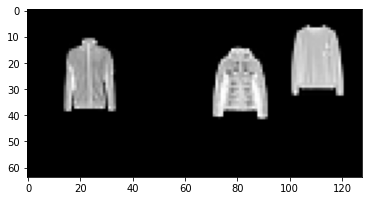

In [ ]:
# Read a pickle file and disply its samples
# image data are stored as unit8 so each element is an integer value between 0 and 255
data = pickle.load( open( './Train.pkl', 'rb' ), encoding='float32')
targets = np.genfromtxt('./TrainLabels.csv', delimiter=',', skip_header=1)[:,1:]-5
plt.imshow(data[1234,:,:],cmap='gray', vmin=0, vmax=256)
print(data.shape, targets.shape)


In [ ]:
# normalize images img=(img-mean)/std
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

# normalize images img=(img-mean)/std with data agument
img_transform_augment = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=1),
    transforms.Normalize([0.5], [0.5]),
    transforms.RandomRotation(13)
])



In [ ]:
# define some classs for reading out data

class MyDataset(Dataset):
    
    def __init__(self, img_file, label_file, transform=None, idx = None):
      """function load training or testing data"""

      # read out img_file (.pkl)
      self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')

      # read out label_file (.csv)
      # convert label by -5
      self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:]-5

      if idx is not None:
        # idx: binary vector for creating training and validation set.
        # Only return samples where idx is not None

        # set idx for target
        self.targets = self.targets[idx]
        # set idx for data
        self.data = self.data[idx]

      # transform to normalize images
      self.transform = transform

    def __len__(self):
      """function to get len of target"""

      return len(self.targets)

    def __getitem__(self, index):
      """function to get img and target"""

      # get img and target
      img, target = self.data[index], int(self.targets[index])
      img = Image.fromarray(img.astype('uint8'), mode='L')
      
      # doing transform to normalize images
      if self.transform is not None:
        img = self.transform(img)

      return img, target

class TestDataset(Dataset):
    
    def __init__(self, img_file, transform=None, idx = None):
      """function load training or testing data"""

      # read out img_file (.pkl)
      self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')

      if idx is not None:
        # idx: binary vector for creating training and validation set.
        # Only return samples where idx is not None

        # set idx for data
        self.data = self.data[idx]

      # transform to normalize images
      self.transform = transform

    def __len__(self):
      """function to get len of target"""

      return len(self.data)

    def __getitem__(self, index):
      """function to get img and target"""

      # get img and target
      img = self.data[index]
      img = Image.fromarray(img.astype('uint8'), mode='L')
      
      # doing transform to normalize images
      if self.transform is not None:
        img = self.transform(img)

      return img

In [ ]:
# Read image data and their label into a Dataset class
# Random split by training =0.8 and testing = 0.2

idx_train, idx_test = train_test_split(np.arange(60000) , test_size=0.2, random_state=42)

# Read data from pkl and label in csv
data_train = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=idx_train)
data_test = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=idx_test)

# Read data from pkl and label with data augment in csv
data_train_augment = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform_augment, idx=idx_train)
data_test_augment = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform_augment, idx=idx_test)

# Read Test data (10000)
test_final = TestDataset('./Test.pkl',transform=img_transform, idx=np.arange(10000))


torch.Size([32, 1, 64, 128])
torch.Size([32])
tensor([8, 4, 8, 3, 7, 8, 6, 6, 7, 1, 8, 1, 7, 3, 8, 3, 4, 8, 2, 7, 8, 6, 1, 2,
        6, 8, 1, 3, 0, 4, 4, 6])


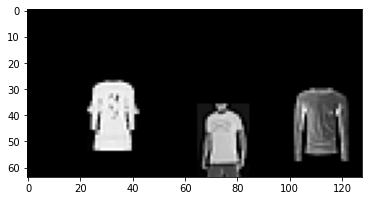

In [ ]:
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)
test_final_loader = DataLoader(test_final, batch_size=batch_size, shuffle=False)


examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# showing data and target shape
print(example_data.shape)
print(example_targets.shape)
print(example_targets)


imgs, labels = (next(iter(train_loader)))
imgs = np.squeeze(imgs)
plt.imshow(imgs[3].cpu().numpy(),cmap='gray', vmin=-1, vmax=1)



torch.Size([32, 1, 64, 128])
torch.Size([32])
tensor([3, 8, 3, 1, 7, 2, 6, 0, 1, 8, 2, 0, 0, 3, 8, 7, 1, 5, 4, 6, 1, 5, 8, 5,
        4, 4, 0, 5, 7, 7, 6, 1])


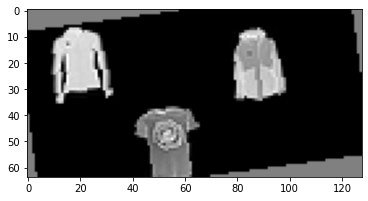

In [ ]:
train_loader_augment = DataLoader(data_train_augment, batch_size=batch_size, shuffle=True)
test_loader_augment = DataLoader(data_test_augment, batch_size=batch_size, shuffle=False)

examples = enumerate(train_loader_augment)
batch_idx, (example_data, example_targets) = next(examples)

# showing data and target shape with data augment
print(example_data.shape)
print(example_targets.shape)
print(example_targets)

imgs, labels = (next(iter(train_loader_augment)))
imgs = np.squeeze(imgs)
plt.imshow(imgs[3].cpu().numpy(),cmap='gray', vmin=-1, vmax=1)

# Define Function 
Define train and test


In [ ]:
def train(epoch, network, loss_mode, train_loader):
  """function for training neural network"""

  # in training mode
  network.train()

  # parameter to calculate training accuracy
  train_correct = 0
  train_total = 0
  train_loss = 0

  # optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
  # scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

  for batch_idx, (data, target) in enumerate(train_loader):


    # transfer data to cuda if available
    data = data.to(device)
    target = target.to(device)
    
    # zero grad after tuning one batch
    optimizer.zero_grad()

    # send data to network
    output = network(data)
    
    # loss model: nll=>negative log liklhood loss, CE=>cross-entropy, nllTA = TA's negative log liklhood loss
    if (loss_mode == "nll"):
      error = nn.NLLLoss()
      loss = error(output, target) 
    elif (loss_mode == "CE"):
      error = nn.CrossEntropyLoss()
      loss = error(output, target)
    elif (loss_mode == "nllTA"):
      loss = F.nll_loss(output, target)


    # backpropogation
    loss.backward()
    # Gardient Descent
    optimizer.step()

    # adding training loss
    train_loss += loss.item()

    # save correct training label
    pred = output.data.max(1, keepdim=True)[1]
    train_correct += pred.eq(target.data.view_as(pred)).sum()
    train_total  += batch_size

    # print out information (epoch, loss, and saving accuracy every 20 batch
    if batch_idx % 150 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), 
        len(train_loader.dataset),
        100. * batch_idx / len(train_loader), 
        loss.item()))
      
      print('Accuracy: {}/{} ({:.0f}%)\n'.format(
      train_correct, train_total,
      100. * train_correct / train_total))

    ## Decay learning rate if needed.  put into for loop
    # scheduler.step()
      
  train_loss /= len(train_loader)

  # print out information (loss, accuarcy) 
  print('\nTraining set: Avg. loss: {:.4f}\n'.format(train_loss))
  print("current learning rate: \n", optimizer.param_groups[0]['lr'])
    
def test(network, loss_mode, test_loader):
  """function for testing neural network"""

  # in testing mode
  network.eval()

  # parameter to calculate testing accuracy
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:

      # transfer data to cuda if available
      data = data.to(device)
      target = target.to(device)

      # send data to network
      output = network(data)

      # loss model: nll=>negative log liklhood loss, CE=>cross-entropy
      # store loss

      if (loss_mode == "nll"):
        error = nn.NLLLoss()
        test_loss += error(output, target).item() 
      elif (loss_mode == "CE"):
        error = nn.CrossEntropyLoss()
        test_loss += error(output, target).item()
      elif (loss_mode == "nllTA"):
        test_loss += F.nll_loss(output, target).item()

      # save correct testing label
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  
  # calculate loss 
  test_loss /= len(test_loader.dataset)

  # print out information (loss, accuarcy) 
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

# Define Network: VGG

In [ ]:
"""
Code Reference: https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/CNN_architectures
"""

# declare number of input and class label
num_in =1
num_class = 9

VGG_types = {
    "VGG11": [64, "M", 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG13": [64, 64, "M", 128, 128, "M", 256, 256, "M", 512, 512, "M", 512, 512, "M"],
    "VGG16": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        "M",
    ],
    "VGG19": [
        64,
        64,
        "M",
        128,
        128,
        "M",
        256,
        256,
        256,
        256,
        "M",
        512,
        512,
        512,
        512,
        "M",
        512,
        512,
        512,
        512,
        "M",
    ],
}

# VGG_net class inherits from nn.Module class
class VGG_net(nn.Module):

    def __init__(self, in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]):
      """constructor"""

      # Call the __init__() function of nn.Module class
      super(VGG_net, self).__init__()
      
      # creating neural network
      # (1) convolutional neural network
      self.in_channels = in_channels
      self.conv_layers = self.create_conv_layers(VGG_type)

      # (2) fully connected neural network

      self.fcs = nn.Sequential(
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p = drop_ratio),
          nn.Linear(4096, 4096),
          nn.ReLU(),
          nn.Dropout(p = drop_ratio),
          nn.Linear(4096, num_classes),
      )

    def create_conv_layers(self, architecture):
      """function help to create convolutional neural network"""

      # list for layers
      layers = []

      # define number of input channel
      in_channels = self.in_channels

      # for loop to construct convolutional neural network according to architecture
      for x in architecture:
          if type(x) == int:
              # create output channel number (when it is not Maxpooling)
              out_channels = x

              # add layer with parameter with convolutional neural network
              layers += [
                  nn.Conv2d(
                      in_channels=in_channels,
                      out_channels=out_channels,
                      kernel_size = kernel_size_CNN,
                      stride=(1, 1),
                      padding=(1, 1),
                  ),

                  # Batchnorm to improve performance
                  nn.BatchNorm2d(x),
                  nn.ReLU(),
              ]

              # input channel for next input
              in_channels = x
  
          elif x == "M":
            # Maxpooling
            layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

      return nn.Sequential(*layers)
        
    def forward(self, x):
      """create forward path for VGG"""
      
      # convolutional neural network
      x = self.conv_layers(x)
      x = x.reshape(x.shape[0], -1)

      # fully connected neural network
      x = self.fcs(x)

      # softmax at the last output layer to get result
      # m = nn.Softmax(dim = 1)
      # return m(x)

      # TA
      return F.log_softmax(x)

# Loading/building neural network

In [ ]:
# flag to check loading or not
Loading = False
# flag to check loading for training or loading for testing
Loading_for_training = True

if (Loading):
  #  initalization network and optimizer before initalization
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)
  # todo adamw
  optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
  checkpoint = torch.load("model_trained_VGG_16_1127_skorch.tar_0.25_dropout.tar")

  # load network and optimizer (these two is Must load!), epoch and loss (optional)
  network.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  # loss = checkpoint['loss']
  
  if (Loading_for_training):
    # load model for continuing training
    network.train()
  else:
    # inferenece
    network.eval()

else:
  #  training network from scratch
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)
  optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)

# check network
print(network)

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(3)]

VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3),

# Model Trainig Method 1
Use Our own train/test function


In [ ]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
# optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# record start time
startall = time.time()

print("inital condition")
print("lr: ", learning_rate)

for epoch in range(1, 20):

  # record each epoch start time
  start_epoch = time.time()

  # doing cross-validation each epoch
  idx_train, idx_test = train_test_split(np.arange(58000) , test_size=0.2)

  # Read data from pkl and label in csv
  data_train = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=idx_train)
  data_test = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=idx_test)

  train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

  # # Read data from pkl and label in csv with augment
  # data_train_augment = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform_augment, idx=idx_train)
  # data_test_augment = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform_augment, idx=idx_test) 

  # train_loader_augment = DataLoader(data_train_augment, batch_size=batch_size, shuffle=True)
  # test_loader_augment = DataLoader(data_test_augment, batch_size=batch_size, shuffle=False)

  ## training 
  # print ("================================================= augment ===========================================")
  # train(epoch, network, loss_mode="nllTA", train_loader = train_loader_augment)
  print ("================================================= without augment ===========================================")
  train(epoch, network, loss_mode="nllTA", train_loader = train_loader)

  # testing 
  test(network, loss_mode="nllTA", test_loader = test_loader)

  print(f"Execution Time For each epoch: {time.time()-start_epoch:.2f} s\n")

print(f"Execution Time: {time.time()-startall:.2f} s")


inital condition
lr:  1.5e-05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/46400 (0%)]	Loss: 0.038479
Accuracy: 16/16 (100%)

Train Epoch: 1 [2400/46400 (5%)]	Loss: 0.000000
Accuracy: 2414/2416 (100%)

Train Epoch: 1 [4800/46400 (10%)]	Loss: 0.000000
Accuracy: 4813/4816 (100%)

Train Epoch: 1 [7200/46400 (16%)]	Loss: 0.000000
Accuracy: 7213/7216 (100%)

Train Epoch: 1 [9600/46400 (21%)]	Loss: 0.000000
Accuracy: 9613/9616 (100%)

Train Epoch: 1 [12000/46400 (26%)]	Loss: 0.000001
Accuracy: 12013/12016 (100%)

Train Epoch: 1 [14400/46400 (31%)]	Loss: 0.000000
Accuracy: 14413/14416 (100%)

Train Epoch: 1 [16800/46400 (36%)]	Loss: 0.000157
Accuracy: 16813/16816 (100%)

Train Epoch: 1 [19200/46400 (41%)]	Loss: 0.000000
Accuracy: 19210/19216 (100%)

Train Epoch: 1 [21600/46400 (47%)]	Loss: 0.000000
Accuracy: 21610/21616 (100%)

Train Epoch: 1 [24000/46400 (52%)]	Loss: 0.003612
Accuracy: 24010/24016 (100%)

Train Epoch: 1 [26400/46400 (57%)]	Loss: 0.000000
Accuracy: 26410/26416 (100%)

Train Epoch: 1 [28800/46400 (62%)]	Loss: 0.000000
Accuracy: 2880

KeyboardInterrupt: ignored

In [ ]:
data_test = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(58001,60000))
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

test(network, loss_mode="nllTA", test_loader = test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0163, Accuracy: 1972/1999 (99%)



In [ ]:
save_file_name_skroch = 'batch16.tar'

In [ ]:
torch.save({
      'model_state_dict': network.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      }, save_file_name_skroch, _use_new_zipfile_serialization=False)

print ("save network! file name: ", save_file_name_skroch)

save network! file name:  batch16.tar


In [ ]:
# flag to check loading or not
Loading = True
# flag to check loading for training or loading for testing
Loading_for_training = True

print (save_file_name_skroch)

if (Loading):
  #  initalization network and optimizer before initalization
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)
  # todo adamw
  optimizer = torch.optim.AdamW(network.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=weight_decay, amsgrad=False)
  checkpoint = torch.load(save_file_name_skroch)

  # load network and optimizer (these two is Must load!), epoch and loss (optional)
  network.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  # epoch = checkpoint['epoch']
  # loss = checkpoint['loss']
  
  if (Loading_for_training):
    # load model for continuing training
    network.train()
  else:
    # inferenece
    network.eval()
    
print (network)

ourown_nlloss_1e-5_20epoch_dropout0.5.tar
VGG_net(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    

# Model Trainig Method 2
Use skorch


In [ ]:
sample_number = 60000
dataset = MyDataset('./Train.pkl', './TrainLabels.csv',transform=img_transform, idx=np.arange(sample_number))
y_data = np.array([y for x, y in iter(dataset)])

In [ ]:
from skorch.callbacks import LRScheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skorch.callbacks import Callback

network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)

torch.manual_seed(0)
learning_rate = 1e-111
weight_decay = 0


# ref: https://github.com/skorch-dev/skorch/issues/505
# Monitor to check learning rate
class Monitor(Callback):
    def on_epoch_end(self, network, **kwargs):
      print("current learning rate: ", network.optimizer_.param_groups[0]['lr'])


#  callbacks function to check and change lr 
callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                    #  factor = 0.5,
                    #  patience = 10, 
                    #  min_lr = learning_rate*0.01
                     ))
    ]


In [ ]:
cnn = NeuralNetClassifier(
    network,
    max_epochs = 10,
    lr= learning_rate,

    criterion = torch.nn.NLLLoss,
    # criterion= torch.nn.CrossEntropyLoss,

    # AdamW
    optimizer = torch.optim.AdamW,
    optimizer__weight_decay=0.01,

    # SGD
    # optimizer = torch.optim.SGD,
    # optimizer__weight_decay = weight_decay,
    # optimizer__momentum = 0.9,
    # optimizer__nesterov = True,

    batch_size = 32,
    device=device,
    iterator_train__num_workers = 4,
    iterator_valid__num_workers = 4,
    callbacks=callbacks,
)

print("inital condition")
print("lr: ", learning_rate, "weight_decay: ", weight_decay)

# record start time
startall = time.time()

# training
cnn.fit(dataset, y=y_data)

print(f"Execution Time: {time.time()-startall:.2f} s")

inital condition
lr:  1e-111 weight_decay:  0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


current learning rate:  1e-111
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.1040           nan  59.9070


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:628: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Execution Time: 83.75 s


In [ ]:
learning_rate = 5e-4
weight_decay = 2e-4

#  callbacks function to check and change lr 
callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                     factor = 0.8,
                     patience = 10, 
                     min_lr = learning_rate*0.01
                     ))
    ]


cnn = NeuralNetClassifier(
    network,
    max_epochs = 100,
    lr= learning_rate,

    # # AdamW
    # optimizer = torch.optim.AdamW,
    # optimizer__weight_decay=weight_decay,

    # SGD
    optimizer = torch.optim.SGD,
    optimizer__weight_decay = weight_decay,
    optimizer__momentum = 0.99,
    optimizer__nesterov = True,

    batch_size = 32,
    device=device,
    iterator_train__num_workers = 4,
    iterator_valid__num_workers = 4,
    callbacks=callbacks,
)

print("inital condition")
print("lr: ", learning_rate, "weight_decay: ", weight_decay)

# record start time
startall = time.time()

# training
cnn.fit(dataset, y=y_data)

print(f"Execution Time: {time.time()-startall:.2f} s")

In [ ]:
save_file_name_skroch = 'high2.tar'

In [ ]:
print ("save network \n")
torch.save({
      'model_state_dict': network.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      }, save_file_name_skroch, _use_new_zipfile_serialization=False)

In [ ]:
learning_rate = 0.0001
weight_decay = 2e-4

#  callbacks function to check and change lr 
callbacks=[
        ('print', Monitor()), ('lr_scheduler',
                     LRScheduler(policy=ReduceLROnPlateau, 
                     monitor = "train_loss",
                     factor = 0.8,
                     patience = 10, 
                     min_lr = learning_rate*0.01
                     ))
    ]


cnn = NeuralNetClassifier(
    network,
    max_epochs = 100,
    lr= learning_rate,

    # # AdamW
    # optimizer = torch.optim.AdamW,
    # optimizer__weight_decay=weight_decay,

    # SGD
    optimizer = torch.optim.SGD,
    optimizer__weight_decay = weight_decay,
    optimizer__momentum = 0.99,
    optimizer__nesterov = True,

    batch_size = 32,
    device=device,
    iterator_train__num_workers = 4,
    iterator_valid__num_workers = 4,
    callbacks=callbacks,
)

print("inital condition")
print("lr: ", learning_rate, "weight_decay: ", weight_decay)

# record start time
startall = time.time()

# training
cnn.fit(dataset, y=y_data)

print(f"Execution Time: {time.time()-startall:.2f} s")

In [ ]:
print (save_file_name_skroch)
# flag to check loading or not
Loading = True
# flag to check loading for training or loading for testing
Loading_for_training = True

if (Loading):
  #  initalization network and optimizer before initalization
  network = VGG_net(in_channels=num_in, num_classes=num_class, VGG_type = VGG_types["VGG16"]).to(device)
  optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
  checkpoint = torch.load(save_file_name_skroch)

  # load network and optimizer (these two is Must load!), epoch and loss (optional)
  network.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

  if (Loading_for_training):
    # load model for continuing training
    network.train()

ourown_nlloss_new_1203_1526pm.tar


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-75-e33944bac080>", line 11, in <module>
    checkpoint = torch.load(save_file_name_skroch)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.6/dist-packages/torch/serialization.py", line 211, in __init__
    super(_open_file, self).__init__(open(name, mode))
OSError: [Errno 107] Transport endpoint is not connected: 'ourown_nlloss_new_1203_1526pm.tar'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core

OSError: ignored

# Test and Save data


In [ ]:
test_final_loader = DataLoader(test_final, batch_size=batch_size, shuffle=False)
y_pred = []

def pred(testdata = test_final_loader):
    # evaluation mode
    network.eval()

    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data in testdata:
          # transfer data to cuda if available
          data = data.to(device)

          output = network(data)
          pred = output.data.max(1, keepdim=True)[1] + 5
          # print (pred.shape)
          y_pred.append(pred.tolist())

    y_pred_final = [item for sublist in y_pred for item in sublist]
    y_pred_final2 = [item for sublist in y_pred_final for item in sublist]
    return y_pred_final2


def store_csv(data, outfile_name):
  rawdata= {'id': np.arange(10000),'class':data}
  a = pd.DataFrame(rawdata, columns = ['id','class'])
  a.to_csv(outfile_name,index=False, header=True)
  print ("store finsih!")

In [ ]:
# record start time
startall = time.time()
y_pred = pred(testdata = test_final_loader)

print(f"Execution Time: {time.time()-startall:.2f} s")

store_csv(y_pred,"submit.csv")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Execution Time: 5.28 s
store finsih!
